<h3><b>Importing required dependencies</b></h3>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle #for saving history object

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


<h3><b>Data Preprocessing</b></h3>

In [2]:
# Define directories and hyperparameters
train_dir =r'D:\testproject\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train'
val_dir = r'D:\testproject\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid'
test_dir=r'D:\testproject\New Plant Diseases Dataset(Augmented)\test\test'


[[[170 153 161]
  [171 154 162]
  [171 154 162]
  ...
  [168 149 155]
  [170 151 157]
  [180 161 167]]

 [[163 146 154]
  [167 150 158]
  [172 155 163]
  ...
  [154 135 141]
  [159 140 146]
  [163 144 150]]

 [[158 141 149]
  [165 148 156]
  [173 156 164]
  ...
  [168 149 155]
  [169 150 156]
  [187 168 174]]

 ...

 [[168 152 163]
  [171 155 166]
  [174 158 169]
  ...
  [176 158 170]
  [175 157 169]
  [184 166 178]]

 [[165 149 160]
  [169 153 164]
  [174 158 169]
  ...
  [145 127 139]
  [115  97 109]
  [173 155 167]]

 [[161 145 156]
  [166 150 161]
  [171 155 166]
  ...
  [143 125 137]
  [169 151 163]
  [170 152 164]]]
(256, 256, 3)


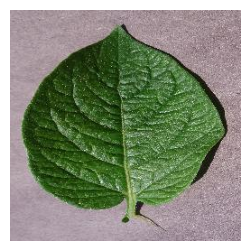

In [3]:
image_path = r'D:\testproject\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train\Potato___healthy\750584fd-72e0-45c8-b37c-97208bd559cc___RS_HL 1885_flipLR.JPG'
# Read the image
img = plt.imread(image_path)
print(img)
print(img.shape)
plt.figure(figsize=(3,3))
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [4]:
# Image and train parameters
img_size = (224, 224)
batch_size = 16
epochs = 20
patience = 5

<h3><b>Splitting of Data for Train, Validation & Test</b></h3>

In [5]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 12750 images belonging to 17 classes.
Found 7809 images belonging to 17 classes.
Found 468 images belonging to 17 classes.


<h3><b>Building AlexNet Model</b></h3>

In [6]:
# Importing AlexNet model architecture
def alexnet_model(input_shape, num_classes):
   model = Sequential()
   # First Convolutional Layer
   model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
   model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
   # Second Convolutional Layer
   model.add(Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'))
   model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
   # Three Convolutional Layers
   model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
   model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'))
   model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
   model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
   # Flatten the output for Dense layers
   model.add(Flatten())
   # First Dense Layer
   model.add(Dense(4096, activation='relu'))
   model.add(Dropout(0.5))
   # Second Dense Layer
   model.add(Dense(4096, activation='relu'))
   model.add(Dropout(0.5))
   # Output Layer
   model.add(Dense(num_classes, activation='softmax'))
   return model


In [7]:
# Building & compiling AlexNet Model
model = alexnet_model(input_shape=(224, 224, 3), num_classes=17)

model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

In [9]:
#Define callbacks
checkpoint = ModelCheckpoint("../models/alexnet_plant_disease_detection.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

<h3><b>Model Training</b></h3>

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

# Save history object
with open('history[alexnet2024].pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Load history object
with open('history[alexnet2024].pkl', 'rb') as f:
    loaded_history = pickle.load(f)

Epoch 1/20
796/796 [==============================] - ETA: 0s - loss: 2.8384 - accuracy: 0.0550
Epoch 1: val_accuracy improved from -inf to 0.06148, saving model to ../models\alexnet_plant_disease_detection.h5
796/796 [==============================] - 145s 172ms/step - loss: 2.8384 - accuracy: 0.0550 - val_loss: 2.8332 - val_accuracy: 0.0615
Epoch 2/20
796/796 [==============================] - ETA: 0s - loss: 2.8340 - accuracy: 0.0576
Epoch 2: val_accuracy did not improve from 0.06148
796/796 [==============================] - 128s 161ms/step - loss: 2.8340 - accuracy: 0.0576 - val_loss: 2.8332 - val_accuracy: 0.0584
Epoch 3/20
796/796 [==============================] - ETA: 0s - loss: 2.8338 - accuracy: 0.0564
Epoch 3: val_accuracy did not improve from 0.06148
796/796 [==============================] - 181s 228ms/step - loss: 2.8338 - accuracy: 0.0564 - val_loss: 2.8333 - val_accuracy: 0.0596
Epoch 4/20
796/796 [==============================] - ETA: 0s - loss: 2.8337 - accuracy: 0.

<h3><b>Evaluation of Model</b></h3>

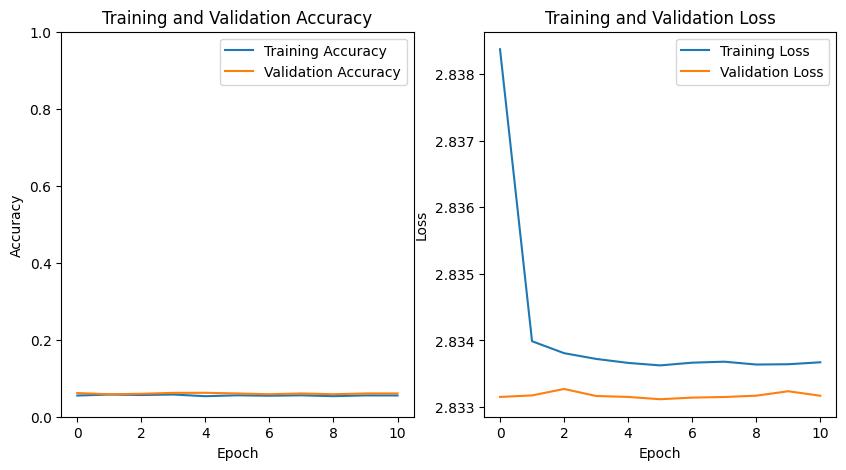

In [11]:
# Evaluation of Model
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
def predictor(test_gen):    
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)    
    for i, p in enumerate(preds):        
        pred_index = np.argmax(p)         
        true_index = test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors = errors + 1
            file = test_gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc = (1 - errors/tests) * 100
    msg = f'There were {errors} errors in {tests} tests for an accuracy of {acc:.2f}'
    print(msg)
    
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    if class_count <= 30:
        cm = confusion_matrix(ytrue, ypred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests, error_list, error_pred_list, f1score, y_pred, y_true

errors, tests, error_list, error_pred_list, f1score, y_pred, y_true = predictor(test_generator)

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('/nTest accuracy:', test_acc)
print('Test Loss:', test_loss)

In [ ]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [ ]:
# Save class indices to a JSON file
with open('class_indices_alexnet.json', 'w') as f:
    json.dump(class_indices, f)